# Effective Stiffness of a Composite Material

## Introduction

This example creates a homogenization linkage to predict the effective stiffness. It starts with a brief background of homogenization theory using the components of the effective elastic stiffness tensor for a composite material. The example uses random microstructures and their average stress values to calibrate the model. It demonstrates the use of Scikit-learn to optimize and fit hyper-parameters. Artificial data is used to calibrate the homogenization pipeline for effective stiffness values and then tested with a test set of microstructures. 


## Linear Elasticity and Effective Elastic Modulus

In this example we create a homogenization linkage that predicts the effective stress component for two-phase microstructures. The boundary conditions in this example are given by, 

$$ u(L, y) = u(0, y) + L\bar{\varepsilon}_{xx}$$

$$ u(0, L) = u(0, 0) = 0  $$

$$ u(x, 0) = u(x, L) $$

where $\bar{\varepsilon}_{xx}$ is the macroscopic strain, $u$ is the displacement in the $x$ direction, and $L$ is the length of the domain. More details about these boundary conditions can be found in [[1]](#References). Using these boundary conditions, $\bar{\sigma}_{xx}$ can be calculated for 6 different types of microstructures given the applied strain, $\bar{\varepsilon}_{xx}$.

In [14]:
import warnings

import dask.array as da
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas
from sklearn.pipeline import Pipeline
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV
from dask_ml.decomposition import PCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from pymks import (
    solve_fe,
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    FlattenTransformer
)

warnings.filterwarnings('ignore')

In [2]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data Generation

A set of periodic microstructures and their volume averaged elastic stress values $\bar{\sigma}_{xx}$ are generated using the multiphase microstructure generator and the built in FE stress solver. The `generate_multiphase` function takes a domain `shape`, a `volume_fraction` for each phase, a `chunks` size for parallel computation and a `grain_size` argument. The `grain_size` is a rough estimate for the desired microstructure feature size.

The following code generates six different types of microstructures each with 200 samples with spatial dimensions of 21 x 21. Each of the six samples will have a different microstructure feature size.

### Note (bug or issue)

The microstructures required shuffling to ensure different classed of microstructure appear in each Dask array chunk. The reason for this is not fully understood currently and requires further investigation.

In [3]:
def shuffle(data):
    tmp = np.array(data)
    np.random.shuffle(tmp)
    return da.from_array(tmp, chunks=data.chunks)

In [6]:
da.random.seed(10)
np.random.seed(10)

tmp = [
    generate_multiphase(shape=(200, 21, 21), grain_size=x, volume_fraction=(0.5, 0.5), chunks=200, percent_variance=0.15)
    for x in [(15, 2), (2, 15), (7, 7), (9, 3), (3, 9), (2, 2)]
]
x_data = shuffle(da.concatenate(tmp))

Next the average stress field, $\bar{\sigma}_{xx}$, for each sample is calculated. 

In [8]:
y_stress = solve_fe(x_data,
                    elastic_modulus=(270, 200),
                    poissons_ratio=(0.28, 0.3),
                    macro_strain=0.001)['stress'][..., 0]

y_data = da.average(y_stress.reshape(y_stress.shape[0], -1), axis=1).persist()

Dask is inherently lazy so does not compute until required. In this case the data is slow to generate so is computed and then stored in RAM using `persist` (see [Dask Best Practices](https://docs.dask.org/en/latest/best-practices.html#persist-when-you-can) for more details). This avoids recomputing the sample data every time the machine learning pipeline is executed below. For a large problem it would be necessary to write the data to disk at this stage. `persist` forces the calculation of the data which can take a few minutes.

In [9]:
x_data

dask.array<array, shape=(1200, 21, 21), dtype=int64, chunksize=(200, 21, 21), chunktype=numpy.ndarray>

In [10]:
y_data

dask.array<mean_agg-aggregate, shape=(1200,), dtype=float64, chunksize=(200,), chunktype=numpy.ndarray>

The array `x_data` contains the microstructure information and has the dimensions 
of `(n_samples, Nx, Ny)`. The array `y_data` contains the average stress value for 
each of the microstructures and has dimensions of `(n_samples,)`. They are each chunked with 200 chunks for parallel computation.

## View Microstructures

The microstructures are plotted using the `plot_microstructures` function. This function takes and number of microstructures and plots them to the screen using a specified color map.

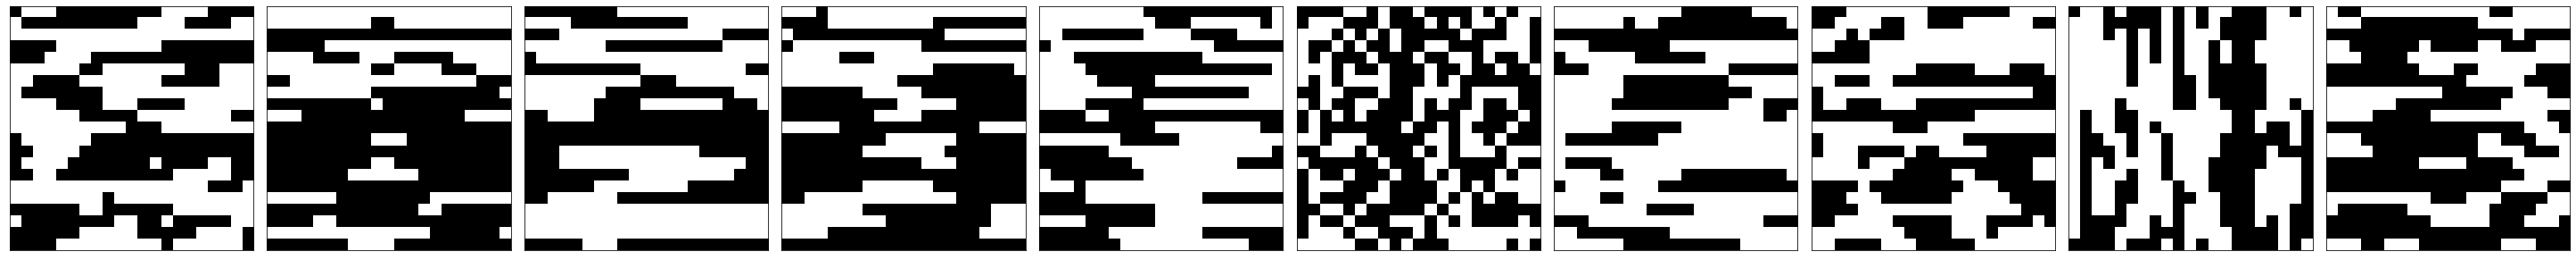

In [11]:
plot_microstructures(*x_data[:10], cmap='gray', colorbar=False)

Four of the six microstructures have grains that are elongated while the other two have equiaxial grains with
varying average sizes

The following is a sample of the stress values, which have already been computed.

In [12]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print('Stress Values', y_data[:10].compute())

Stress Values [0.24150339 0.2505754  0.24072841 0.24901416 0.24012803 0.24833059
 0.23702407 0.24089572 0.24112834 0.24825679]


Now that the datasets are evaluated a homogenization workflow can be constructed to predict stress values for new microstructures.

## Homogenization Workflow

The homogenization pipeline presented in this notebook takes in a dataset and 

 - calculates the 2-point statistics  
 - performs [dimensionality reduction](http://en.wikipedia.org/wiki/Dimensionality_reduction) using [Prinicple Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA)  
 - and fits a [polynomial regression model](http://en.wikipedia.org/wiki/Polynomial_regression) model to the low-dimensional representation.  

This workflow has been shown to accurately predict effective properties in several examples [[2]](#References)[[3]](#References), and requires the specification of the number of components used in dimensionality reduction and the order of the polynomial we will be using for the polynomial regression. This example shows how to use tools from Scikit-learn to try and optimize our selection for these two hyper-parameters.


## Modeling

To create the homogenization workflow the steps used pipeline need to be defined. For this particular example, there are only 2 discrete phases and so the `PrimitiveTransformer` is appropriate. The statistical representation of the discretized microstructures is generated using the `TwoPointCorrelation` class. The data is then flattened from a 2-dimensional statistical representation to 1 dimension followed by a PCA step and then a polynomial regression step to develop the desired structure-property linkage. 

### Note (issue or bug)

There are currently two issues with the pipeline.

 - The `svd_solver='full'` argument is required in the pipeline as the results are not correct without it. This might be an issue with Dask's PCA algorithms and needs further investigation.
 
 - Dask's `LinearRegression` module does not seem to solve this problem correctly and gives very different results to Sklearn's. Needs further investigation

In [15]:
pca_steps = [
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=21,correlations=[(1,1),(0,0)])),
    ("flatten", FlattenTransformer()),  
    ("pca", PCA(svd_solver='full', n_components=40))
]

parallel_steps = pca_steps + [("poly", PolynomialFeatures())]

serial_steps = [("regressor", LinearRegression(normalize=False))]

The complete pipeline, `pipeline`, with all the steps is used for the final predictions. The `pca_pipeline` is used to observe the variance versus `n_components`. The `parallel_pipeline` removes the final step which is in serial to demonstrate the task graph.

In [16]:
pipeline = Pipeline(parallel_steps + serial_steps)
pca_pipeline = Pipeline(pca_steps)
parallel_pipeline = Pipeline(parallel_steps)

## Visualize the task graph

The pipeline results in an entirely lazy calulation. The task graph can be viewed to check that it remains parallel and doesn't gather all the data. The calculation has not been evaluated yet, since the graph is generated with only a small part of the data.

### Note (issue or bug)

Note that for some reason the `y_data` passed into `fit` is required to be a Numpy array and doens't work with a correctly chunked Dask array, see the [github issue](https://github.com/materialsinnovation/pymks/issues/474).

Fontconfig warning: "/etc/fonts/fonts.conf", line 5: unknown element "its:rules"
Fontconfig warning: "/etc/fonts/fonts.conf", line 6: unknown element "its:translateRule"
Fontconfig error: "/etc/fonts/fonts.conf", line 6: invalid attribute 'translate'
Fontconfig error: "/etc/fonts/fonts.conf", line 6: invalid attribute 'selector'
Fontconfig error: "/etc/fonts/fonts.conf", line 7: invalid attribute 'xmlns:its'
Fontconfig error: "/etc/fonts/fonts.conf", line 7: invalid attribute 'version'
Fontconfig warning: "/etc/fonts/fonts.conf", line 9: unknown element "description"
Fontconfig error: Cannot load config file from /etc/fonts/fonts.conf


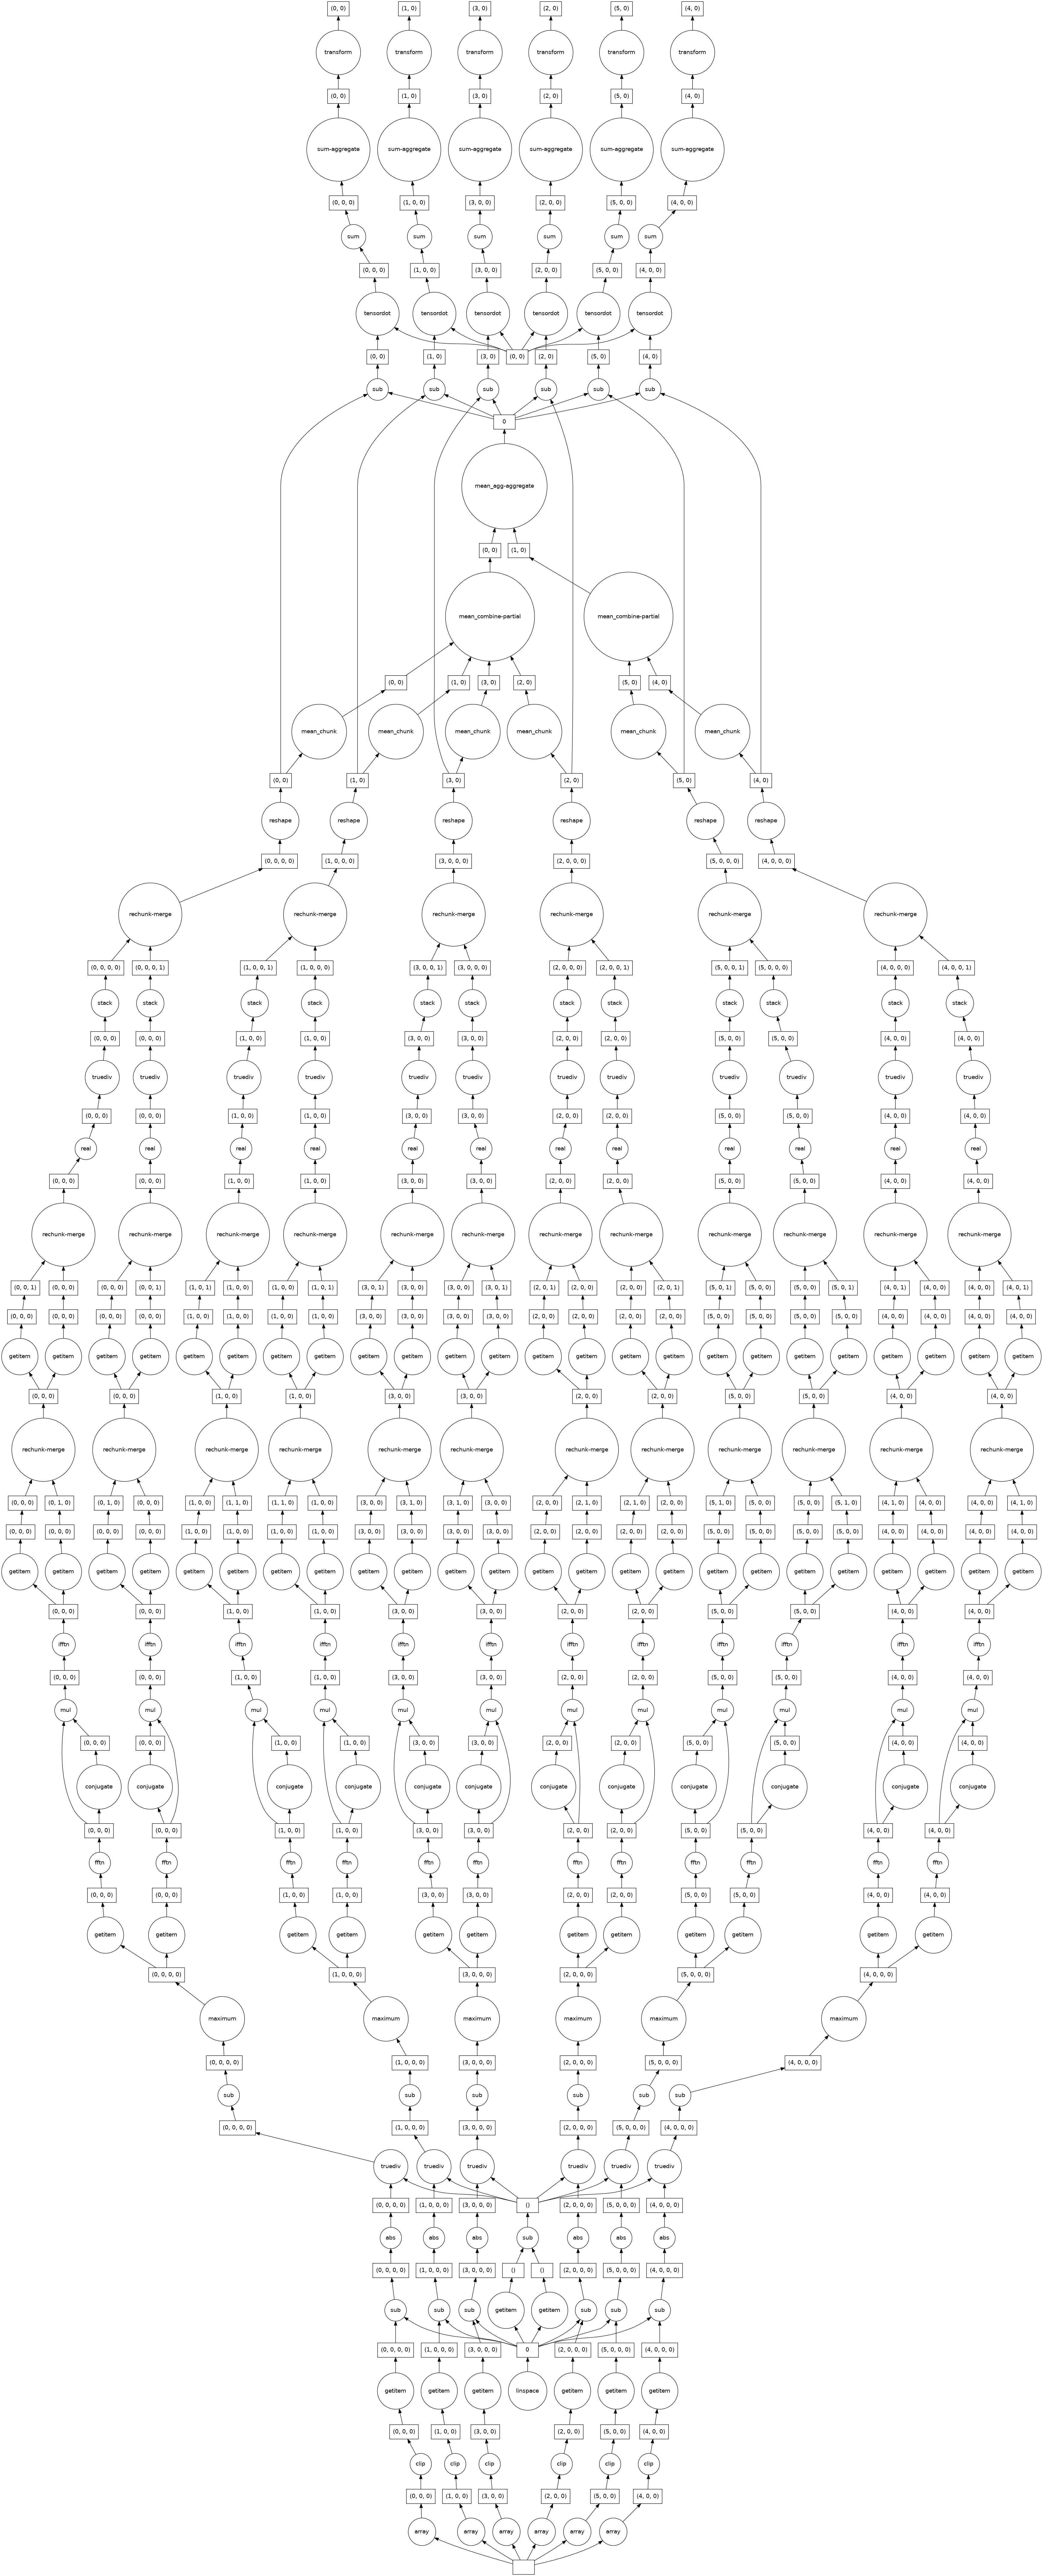

In [17]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

parallel_pipeline.fit(x_data).transform(x_data).visualize()

## Observing variance changes with components

To start with, the variance changes are observed as a function of the number of components.
In general for SVD as well as PCA the amount of variance captured in each component decreases
as the component number increases.
This means that as the number of components used in the dimensionality reduction increases the percentage of the variance will asymptotically approach 100%. This will be checked below

In [18]:
pca_pipeline.fit(x_data).transform(x_data)
variance = pca_pipeline.named_steps['pca'].explained_variance_ratio_
n_components = len(variance)

Plot the cumulative variance changes versus number of components.

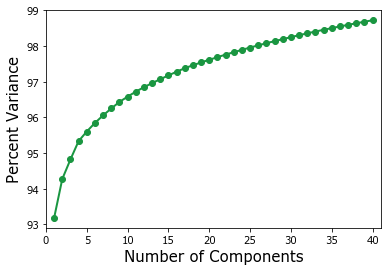

In [19]:
n_components = len(variance)

plt.plot(
    range(1, n_components + 1),
    np.cumsum(variance * 100),
    'o-',
    color='#1a9641',
    linewidth=2
)
plt.xlabel('Number of Components', fontsize=15)
plt.xlim(0, n_components + 1)
plt.ylabel('Percent Variance', fontsize=15)
plt.show()

Over 95 percent of the variance is captured with the first 5 components. This means that the model may only need a few components to predict the average stress.

## Optimize hyper-parameters

This section optimizes the number of components and the polynomial order by splitting the data into test and training sets using the `train_test_spilt` function.

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x_data.reshape(x_data.shape[0], -1), y_data,
                                                    test_size=0.2, random_state=3)

The component count and polynomial order is optimized using cross-validation via [GridSeachCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

A dictionary of possible parameters, `params_to_tune` is passed to `GridSearchCV`. `n_components` varies from 1 to 11 and `degree` varies from 1 to 3.

In [21]:
params_to_tune = {'pca__n_components': np.arange(1, 12),'poly__degree': np.arange(1, 4)}

grid_search = GridSearchCV(pipeline, params_to_tune).fit(x_train, y_train)

`GridSearchCV` stores the hyper-parameters that supply the best fit.

In [22]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print('GridSearchCV.best_params_')
print('degree:', grid_search.best_params_.get('poly__degree'))
print('n_components:', grid_search.best_params_.get('pca__n_components'))

GridSearchCV.best_params_
degree: 3
n_components: 6


In [23]:
assert(2 <= grid_search.best_params_.get('poly__degree') <= 3)
assert(6 <= grid_search.best_params_.get('pca__n_components') <= 12)

In the above the best degree order varies between 2 and 3 and the number of components between 6 and 12

The following plots R-squared vs Number of PC components plot for degree 1, 2 and 3 polynomials.

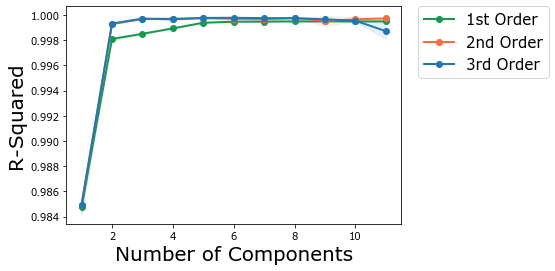

In [24]:
def plot_line(x, mean, std_dev, color, label):
    plt.fill_between(x, mean - std_dev, mean + std_dev, alpha=0.1, color=color)
    plt.plot(x, mean, 'o-', color=color, label=label, linewidth=2)
    
def plot(dfs):
    [plot_line(df_.n_comp.astype(int), df_.mean_, df_.std_, df_.color.iloc[0], df_.label.iloc[0]) for df_ in dfs]
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
    plt.ticklabel_format(style='sci', axis='y')
    plt.ylabel('R-Squared', fontsize=20)
    plt.xlabel('Number of Components', fontsize=20)
    plt.show()

def add_labels(df):
    return df.assign(
        label=df.degree.map(lambda n: {1: '1st Order', 2: '2nd Order', 3: '3rd Order'}[n]),
        color=df.degree.map(lambda n: {1: '#1a9850', 2: '#f46d43', 3: '#1f78b4'}[n]),
    )
    
def rename(df):
    return df.rename(
        dict(
            param_poly__degree='degree',
            param_pca__n_components='n_comp',
            mean_test_score='mean_',
            std_test_score='std_',
        ),
        axis=1
    )

def groupby(df, col):
    gb = df.groupby(col)
    return [gb.get_group(x) for x in gb.groups]

df = groupby(
    add_labels(
        rename(
            pandas.DataFrame(grid_search.cv_results_)
        )
    ),
    'degree'
)

plot(df)

Use the best model from the grid scores.

In [25]:
model = grid_search.best_estimator_

## Check the low-dimensional representation

Check if the low-dimensional representation of the 
new data is similar to the low-dimensional representation of the train data by visualizing the microstructures in PC space.


In [26]:
pca_pipeline.set_params(pca__n_components=3)

Pipeline(memory=None,
         steps=[('discritize',
                 PrimitiveTransformer(chunks=None, max_=1.0, min_=0.0,
                                      n_state=2)),
                ('correlations',
                 TwoPointCorrelation(correlations=[(1, 1), (0, 0)], cutoff=21,
                                     periodic_boundary=True)),
                ('flatten', FlattenTransformer()),
                ('pca',
                 PCA(copy=True, iterated_power=0, n_components=3,
                     random_state=None, svd_solver='full', tol=0.0,
                     whiten=False))],
         verbose=False)

In [27]:
x_trans_train = pca_pipeline.fit(x_train).transform(x_train).compute()
x_trans_test = pca_pipeline.transform(x_test).compute()

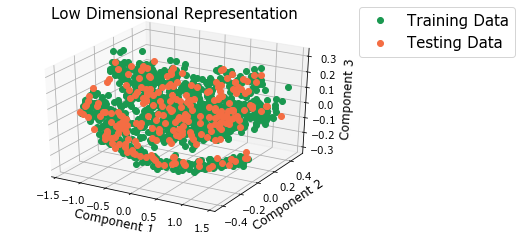

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Component 1', fontsize=12)
ax.set_ylabel('Component 2', fontsize=12)
ax.set_zlabel('Component 3', fontsize=12)
ax.plot(*x_trans_train.T, 'o', label='Training Data', color='#1a9850')
ax.plot(*x_trans_test.T, 'o', label='Testing Data', color='#f46d43')
plt.title('Low Dimensional Representation', fontsize=15)
plt.legend(loc=1, borderaxespad=0., fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0., fontsize=15)
plt.show()

## Prediction using Homogenization Pipeline

The `n_components` and `degree` parameters have been selected above so the model can now be used for a prediction

### Note (issue or bug)

For some reason the `y_data` passed into `fit` is required to be a Numpy array and doens't work with a correctly chunked Dask array, see the [github issue](https://github.com/materialsinnovation/pymks/issues/474).

In [29]:
model.fit(x_train, np.array(y_train));

In [30]:
y_predict = model.predict(x_test)

In [31]:
y_train_predict = model.predict(x_train)

In [32]:
#PYTEST_VALIDATE_IGNORE_OUTPUT
assert (np.allclose(model.score(x_test, y_test), 1, rtol=1e-2))
print("R-squared %.4f" % model.score(x_test, y_test))

R-squared 0.9998


View one actual and predicted stress value for each of the 6 microstructure types to see how they compare.

In [35]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print('Actual Stress   ', y_test[::20].compute())
print('Predicted Stress', y_predict[::20])

Actual Stress    [0.24526421 0.23966356 0.24959968 0.23797395 0.25289738 0.2511737
 0.252053   0.25273297 0.24956816 0.24350162 0.23926452 0.23985281]
Predicted Stress [0.24520173 0.23980971 0.24924062 0.23801932 0.25295501 0.25120957
 0.25214891 0.25279811 0.24954016 0.2434488  0.23926167 0.23981704]


Lastly, evaluate our prediction by looking at a parity plot. 

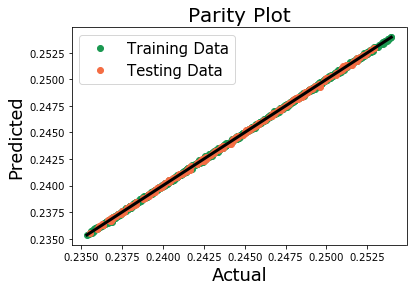

In [36]:
fit_data = np.array([y_train.compute(), y_train_predict])
pred_data = np.array([y_test.compute(), y_predict])

y_total = np.concatenate((fit_data, pred_data), axis=-1)
line = np.min(y_total), np.max(y_total)

plt.plot(fit_data[0], fit_data[1], 'o', color='#1a9850', label='Training Data')
plt.plot(pred_data[0], pred_data[1], 'o', color='#f46d43', label='Testing Data')
plt.plot(line, line, '-', linewidth=3, color='#000000')
plt.title('Parity Plot', fontsize=20)
plt.xlabel('Actual', fontsize=18)
plt.ylabel('Predicted', fontsize=18)
plt.legend(loc=2, fontsize=15)
plt.show()

The `pipeline` is a good homogenization linkage for the effective stiffness for the 6 different microstructures and has predicted the average stress values for our new microstructures reasonably well.

## References

<a id="ref1"></a>
[1] Landi, G., S.R. Niezgoda, S.R. Kalidindi, Multi-scale modeling of elastic response of three-dimensional voxel-based microstructure datasets using novel DFT-based knowledge systems. Acta Materialia, 2009. 58 (7): p. 2716-2725 [doi:10.1016/j.actamat.2010.01.007](http://dx.doi.org/10.1016/j.actamat.2010.01.007).

<a id="ref2"></a>
[2] Çeçen, A., et al. "A data-driven approach to establishing microstructure–property relationships in porous transport layers of polymer electrolyte fuel cells." Journal of Power Sources 245 (2014): 144-153. [doi:10.1016/j.jpowsour.2013.06.100](http://dx.doi.org/10.1016/j.jpowsour.2013.06.100)

<a id="ref3"></a>
[3] Deshpande, P. D., et al. "Application of Statistical and Machine Learning Techniques for Correlating Properties to Composition and Manufacturing Processes of Steels." 2 World Congress on Integrated Computational Materials Engineering. John Wiley & Sons, Inc.  [doi:10.1002/9781118767061.ch25](http://dx.doi.org/10.1002/9781118767061.ch25)
